# Optimisation of a Neocortical Layer 5 Pyramidal Cell in Arbor

This notebook shows you how to optimise the maximal conductance of Neocortical Layer 5 Pyramidal Cell as used in Markram et al. 2015 using Arbor as the simulator.

Author of this script: Werner Van Geit @ Blue Brain Project

Choice of parameters, protocols and other settings was done by Etay Hay @ HUJI

What's described here is a more advanced use of BluePyOpt. We suggest to first go through the introductary example here: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/simplecell/simplecell.ipynb

**If you use the methods in this notebook, we ask you to cite the following publications when publishing your research:**

Van Geit, W., M. Gevaert, G. Chindemi, C. Rössert, J.-D. Courcol, E. Muller, F. Schürmann, I. Segev, and H. Markram (2016, March). BluePyOpt: Leveraging open source software and cloud infrastructure to optimise model parameters in neuroscience. ArXiv e-prints.
http://arxiv.org/abs/1603.00500

Markram, H., E. Muller, S. Ramaswamy, M. W. Reimann, M. Abdellah, C. A. Sanchez, A. Ailamaki, L. Alonso-Nanclares, N. Antille, S. Arsever, et al. (2015). Reconstruction and simulation of neocortical microcircuitry. Cell 163(2), 456–492.
http://www.cell.com/abstract/S0092-8674%2815%2901191-5

Some of the modules loaded in this script are located in the L5PC example folder: https://github.com/BlueBrain/BluePyOpt/tree/master/examples/l5pc 

We first load the bluepyopt python module, the ephys submodule and some helper functionality

In [1]:
%load_ext autoreload
%autoreload

from __future__ import print_function

!nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

%matplotlib inline
import matplotlib.pyplot as plt

/home/lukasd/src/arbor/dev/BluePyOpt/examples/l5pc
Mod files: "mechanisms/CaDynamics_E2.mod" "mechanisms/Ca_HVA.mod" "mechanisms/Ca_LVAst.mod" "mechanisms/Ih.mod" "mechanisms/Im.mod" "mechanisms/K_Pst.mod" "mechanisms/K_Tst.mod" "mechanisms/Nap_Et2.mod" "mechanisms/NaTa_t.mod" "mechanisms/NaTs2_t.mod" "mechanisms/SK_E2.mod" "mechanisms/SKv3_1.mod"

Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.c
 -> NMODL ../mechanisms/CaDynamics_E2.mod
x86_64-linux-gnu-gcc -O2   -I.   -I/home/lukasd/src/arbor/dev/venv/lib/python3.8/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
(cd "../mechanisms"; MODLUNIT=/home/lukasd/src/arbor/dev/venv/lib/python3.8/site-packages/neuron/.data/share/nrn/lib/nrnunits.lib /home/lukasd/src/arbor/dev/venv/lib/python3.8/site-packages/neuron/.data/bin/nocmodl CaDynamics_E2.mod -o "/home/lukasd/src/arbor/dev/BluePyOpt/examples/l5pc/x86_64")
 -> NMODL ../mechanisms/Ca_HVA.mod
(cd "../mechanisms"; 

Enable the code below to enable debug level logging

In [2]:
# import logging                                                                      
# logging.basicConfig()                                                               
# logger = logging.getLogger()                                                        
# logger.setLevel(logging.DEBUG)   

## Model description

### Morphology

We're using a complex reconstructed morphology of an L5PC cell. Let's visualise this with the BlueBrain NeuroM software. Alternatively, the cell model can be exported to JSON/ACC by running

```shell
./generate_acc.py --replace-axon --output <output-dir>
```

The output can be visualized with the Arbor GUI (graphical user interface) as shown in the [documentation](https://docs.arbor-sim.org/en/latest/tutorial/single_cell_bluepyopt.html).


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


/tmp/ipykernel_466037/1031438697.py:3: NeuroMDeprecationWarning: `neurom.io.utils.load_neuron` is deprecated in favor of `neurom.io.utils.load_morphology`
  neurom.viewer.draw(neurom.load_neuron('morphology/C060114A7.asc'));


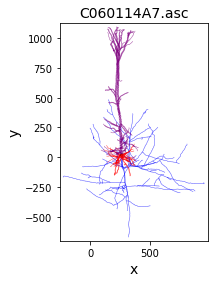

In [3]:
!pip install neurom --upgrade
import neurom.viewer
neurom.viewer.draw(neurom.load_neuron('morphology/C060114A7.asc'));

To load the morphology we create a NrnFileMorphology object. We set 'do_replace_axon' to True to replace the axon with a AIS.

In [4]:
morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
print(str(morphology))

morphology/C060114A7.asc


### Parameters

Since we have many parameters in this model, they are stored in a json file: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/l5pc/config/parameters.json

In [5]:
import json
param_configs = json.load(open('config/parameters.json'))
print([param_config['param_name'] for param_config in param_configs])

['g_pas', 'e_pas', 'cm', 'Ra', 'v_init', 'celsius', 'ena', 'ek', 'cm', 'ena', 'ek', 'cm', 'ena', 'ek', 'gIhbar_Ih', 'gNaTs2_tbar_NaTs2_t', 'gSKv3_1bar_SKv3_1', 'gImbar_Im', 'gIhbar_Ih', 'gNaTa_tbar_NaTa_t', 'gNap_Et2bar_Nap_Et2', 'gK_Pstbar_K_Pst', 'gK_Tstbar_K_Tst', 'gSK_E2bar_SK_E2', 'gSKv3_1bar_SKv3_1', 'gCa_HVAbar_Ca_HVA', 'gCa_LVAstbar_Ca_LVAst', 'gamma_CaDynamics_E2', 'decay_CaDynamics_E2', 'gNaTs2_tbar_NaTs2_t', 'gSKv3_1bar_SKv3_1', 'gSK_E2bar_SK_E2', 'gCa_HVAbar_Ca_HVA', 'gCa_LVAstbar_Ca_LVAst', 'gamma_CaDynamics_E2', 'decay_CaDynamics_E2', 'gIhbar_Ih']


The directory that contains this notebook has a module that will load all the parameters in BluePyOpt Parameter objects

In [6]:
import l5pc_model
parameters = l5pc_model.define_parameters()
print('\n'.join('%s' % param for param in parameters))

g_pas.all: ['all'] g_pas = 3e-05
e_pas.all: ['all'] e_pas = -75
cm.all: ['all'] cm = 1
Ra.all: ['all'] Ra = 100
v_init: v_init = -65
celsius: celsius = 34
ena.apical: ['apical'] ena = 50
ek.apical: ['apical'] ek = -85
cm.apical: ['apical'] cm = 2
ena.somatic: ['somatic'] ena = 50
ek.somatic: ['somatic'] ek = -85
cm.basal: ['basal'] cm = 2
ena.axonal: ['axonal'] ena = 50
ek.axonal: ['axonal'] ek = -85
gIhbar_Ih.basal: ['basal'] gIhbar_Ih = 8e-05
gNaTs2_tbar_NaTs2_t.apical: ['apical'] gNaTs2_tbar_NaTs2_t = [0, 0.04]
gSKv3_1bar_SKv3_1.apical: ['apical'] gSKv3_1bar_SKv3_1 = [0, 0.04]
gImbar_Im.apical: ['apical'] gImbar_Im = [0, 0.001]
gIhbar_Ih.apical: ['apical'] gIhbar_Ih = 8e-05
gNaTa_tbar_NaTa_t.axonal: ['axonal'] gNaTa_tbar_NaTa_t = [0, 4]
gNap_Et2bar_Nap_Et2.axonal: ['axonal'] gNap_Et2bar_Nap_Et2 = [0, 4]
gK_Pstbar_K_Pst.axonal: ['axonal'] gK_Pstbar_K_Pst = [0, 1]
gK_Tstbar_K_Tst.axonal: ['axonal'] gK_Tstbar_K_Tst = [0, 0.1]
gSK_E2bar_SK_E2.axonal: ['axonal'] gSK_E2bar_SK_E2 = [0, 0.1

As you can see there are two types of parameters, parameters with a fixed value and parameters with bounds. The latter will be optimised by the algorithm.

### Mechanism

We also need to add all the necessary mechanisms, like ion channels to the model. 
The configuration of the mechanisms is also stored in a json file, and can be loaded in a similar way.

In [7]:
mechanisms = l5pc_model.define_mechanisms()
print('\n'.join('%s' % mech for mech in mechanisms))

Ih.basal: Ih at ['basal']
pas.all: pas at ['all']
Ih.apical: Ih at ['apical']
Im.apical: Im at ['apical']
SKv3_1.apical: SKv3_1 at ['apical']
NaTs2_t.apical: NaTs2_t at ['apical']
Ca_LVAst.axonal: Ca_LVAst at ['axonal']
Ca_HVA.axonal: Ca_HVA at ['axonal']
CaDynamics_E2.axonal: CaDynamics_E2 at ['axonal']
SKv3_1.axonal: SKv3_1 at ['axonal']
SK_E2.axonal: SK_E2 at ['axonal']
K_Tst.axonal: K_Tst at ['axonal']
K_Pst.axonal: K_Pst at ['axonal']
Nap_Et2.axonal: Nap_Et2 at ['axonal']
NaTa_t.axonal: NaTa_t at ['axonal']
NaTs2_t.somatic: NaTs2_t at ['somatic']
SKv3_1.somatic: SKv3_1 at ['somatic']
SK_E2.somatic: SK_E2 at ['somatic']
CaDynamics_E2.somatic: CaDynamics_E2 at ['somatic']
Ca_HVA.somatic: Ca_HVA at ['somatic']
Ca_LVAst.somatic: Ca_LVAst at ['somatic']
Ih.somatic: Ih at ['somatic']


# Cell model

With the morphology, mechanisms and parameters we can build the cell model. If we use axon-replacement, we must 3d-instantiate the morphology first in the Neuron simulator to obtain a faithful representation in Arbor.

Note that before `l5pc_cell` can subsequently be used in a Neuron protocol, `l5pc_cell.destroy(sim=nrn_sim)` must be invoked. 

In [8]:
l5pc_cell = ephys.models.CellModel('l5pc', morph=morphology, mechs=mechanisms, params=parameters)

if morphology.do_replace_axon:
    nrn_sim = ephys.simulators.NrnSimulator()
    # invoke this before exporting an axon-replaced morphology to JSON/ACC-format
    l5pc_cell.instantiate_morphology_3d(nrn_sim)

print(l5pc_cell)

l5pc:
  morphology:
    morphology/C060114A7.asc
  mechanisms:
    Ih.basal: Ih at ['basal']
    pas.all: pas at ['all']
    Ih.apical: Ih at ['apical']
    Im.apical: Im at ['apical']
    SKv3_1.apical: SKv3_1 at ['apical']
    NaTs2_t.apical: NaTs2_t at ['apical']
    Ca_LVAst.axonal: Ca_LVAst at ['axonal']
    Ca_HVA.axonal: Ca_HVA at ['axonal']
    CaDynamics_E2.axonal: CaDynamics_E2 at ['axonal']
    SKv3_1.axonal: SKv3_1 at ['axonal']
    SK_E2.axonal: SK_E2 at ['axonal']
    K_Tst.axonal: K_Tst at ['axonal']
    K_Pst.axonal: K_Pst at ['axonal']
    Nap_Et2.axonal: Nap_Et2 at ['axonal']
    NaTa_t.axonal: NaTa_t at ['axonal']
    NaTs2_t.somatic: NaTs2_t at ['somatic']
    SKv3_1.somatic: SKv3_1 at ['somatic']
    SK_E2.somatic: SK_E2 at ['somatic']
    CaDynamics_E2.somatic: CaDynamics_E2 at ['somatic']
    Ca_HVA.somatic: Ca_HVA at ['somatic']
    Ca_LVAst.somatic: Ca_LVAst at ['somatic']
    Ih.somatic: Ih at ['somatic']
  params:
    g_pas.all: ['all'] g_pas = 3e-05
    e_pa

For use in the cell evaluator later, we need to make a list of the name of the parameters we are going to optimise.
These are the parameters that are not frozen.

In [9]:
param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

## Protocols

Now that we have a cell model, we can apply protocols to it. The protocols are also stored in a json file.

In [10]:
proto_configs = json.load(open('config/protocols.json'))
print(proto_configs)

{'bAP': {'stimuli': [{'delay': 295, 'amp': 1.9, 'duration': 5, 'totduration': 600}], 'extra_recordings': [{'var': 'v', 'somadistance': 660, 'type': 'somadistance', 'name': 'dend1', 'seclist_name': 'apical', 'arbor_branch_index': 251, 'arbor_branch_index_with_replaced_axon': 123}, {'var': 'v', 'somadistance': 800, 'type': 'somadistance', 'name': 'dend2', 'seclist_name': 'apical', 'arbor_branch_index': 251, 'arbor_branch_index_with_replaced_axon': 123}]}, 'Step3': {'stimuli': [{'delay': 700, 'amp': 0.95, 'duration': 2000, 'totduration': 3000}, {'delay': 0, 'amp': -0.126, 'duration': 3000, 'totduration': 3000}]}, 'Step2': {'stimuli': [{'delay': 700, 'amp': 0.562, 'duration': 2000, 'totduration': 3000}, {'delay': 0, 'amp': -0.126, 'duration': 3000, 'totduration': 3000}]}, 'Step1': {'stimuli': [{'delay': 700, 'amp': 0.458, 'duration': 2000, 'totduration': 3000}, {'delay': 0, 'amp': -0.126, 'duration': 3000, 'totduration': 3000}]}}


And they can be automatically loaded

In [11]:
import l5pc_evaluator
fitness_protocols = l5pc_evaluator.define_protocols(do_replace_axon=morphology.do_replace_axon, sim='arb')
print('\n'.join('%s' % protocol for protocol in fitness_protocols.values()))

bAP:
  stimuli:
    Square pulse amp 1.900000 delay 295.000000 duration 5.000000 totdur 600.000000 at ArbBranchRelLocation '(locset-def "soma" (location 0 0.5))'
  recordings:
    bAP.soma.v: v at ArbBranchRelLocation '(locset-def "soma" (location 0 0.5))'
    bAP.dend1.v: v at ArbLocsetLocation (locset-def "dend1" (restrict (distal-translate (proximal (region "apic")) 660) (proximal-interval (distal (branch 123)))))
    bAP.dend2.v: v at ArbLocsetLocation (locset-def "dend2" (restrict (distal-translate (proximal (region "apic")) 800) (proximal-interval (distal (branch 123)))))

Step3:
  stimuli:
    Square pulse amp 0.950000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at ArbBranchRelLocation '(locset-def "soma" (location 0 0.5))'
    Square pulse amp -0.126000 delay 0.000000 duration 3000.000000 totdur 3000.000000 at ArbBranchRelLocation '(locset-def "soma" (location 0 0.5))'
  recordings:
    Step3.soma.v: v at ArbBranchRelLocation '(locset-def "soma" (location 0 0.5))'


## eFeatures

For every protocol we need to define which eFeatures will be used as objectives of the optimisation algorithm.

In [12]:
feature_configs = json.load(open('config/features.json'))
pp.pprint(feature_configs)

{ 'Step1': { 'soma': { 'AHP_depth_abs': [-60.3636, 2.3018],
                       'AHP_depth_abs_slow': [-61.1513, 2.3385],
                       'AHP_slow_time': [0.1599, 0.0483],
                       'AP_height': [25.0141, 3.1463],
                       'AP_width': [3.5312, 0.8592],
                       'ISI_CV': [0.109, 0.1217],
                       'adaptation_index2': [0.0047, 0.0514],
                       'doublet_ISI': [62.75, 9.6667],
                       'mean_frequency': [6, 1.2222],
                       'time_to_first_spike': [27.25, 5.7222]}},
  'Step2': { 'soma': { 'AHP_depth_abs': [-59.9055, 1.8329],
                       'AHP_depth_abs_slow': [-60.2471, 1.8972],
                       'AHP_slow_time': [0.1676, 0.0339],
                       'AP_height': [27.1003, 3.1463],
                       'AP_width': [2.7917, 0.7499],
                       'ISI_CV': [0.0674, 0.075],
                       'adaptation_index2': [0.005, 0.0067],
                     

In [13]:
fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols)
print(fitness_calculator)

objectives:
  ( AP_width for {'': 'bAP.soma.v'} with stim start 295 and end 600, exp mean 2.0 and std 0.5 and AP threshold override -20 )
  ( AP_height for {'': 'bAP.soma.v'} with stim start 295 and end 600, exp mean 25.0 and std 5.0 and AP threshold override -20 )
  ( Spikecount for {'': 'bAP.soma.v'} with stim start 295 and end 600, exp mean 1.0 and std 0.01 and AP threshold override -20 )
  ( AP_amplitude_from_voltagebase for {'': 'bAP.dend1.v'} with stim start 295 and end 600, exp mean 45 and std 10 and AP threshold override -55 )
  ( AP_amplitude_from_voltagebase for {'': 'bAP.dend2.v'} with stim start 295 and end 600, exp mean 36 and std 9.33 and AP threshold override -55 )
  ( AP_height for {'': 'Step3.soma.v'} with stim start 700 and end 2700, exp mean 19.7207 and std 3.7204 and AP threshold override -20 )
  ( AHP_slow_time for {'': 'Step3.soma.v'} with stim start 700 and end 2700, exp mean 0.1968 and std 0.0112 and AP threshold override -20 )
  ( ISI_CV for {'': 'Step3.soma.v'

## Simulator

We need to define which simulator we will use. In this case it will be Arbor, i.e. the ArbSimulator class

In [14]:
sim = ephys.simulators.ArbSimulator()

## Evaluator

With all the components defined above we can build a cell evaluator

In [15]:
evaluator = ephys.evaluators.CellEvaluator(                                          
        cell_model=l5pc_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)  

This evaluator can be used to run the protocols. The original parameter values for the Markram et al. 2015 L5PC model are:

In [16]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}


Running the responses is as easy as passing the protocols and parameters to the evaluator. (The line below will take some time to execute)

In [17]:
release_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=release_params)

We can now plot all the responses

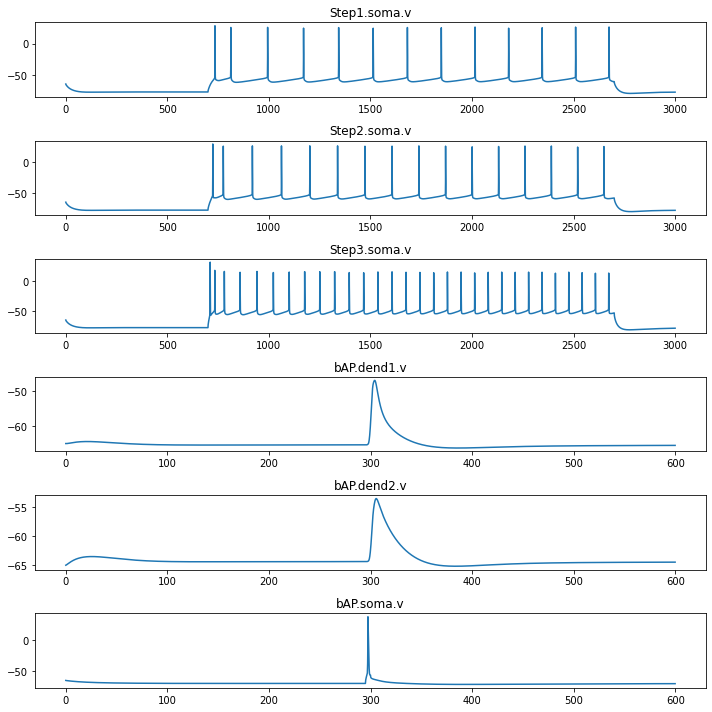

In [18]:
def plot_responses(responses):
    fig, axes = plt.subplots(len(responses), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(responses.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
plot_responses(release_responses)

Running an optimisation of the parameters now has become very easy. 
Of course running the L5PC optimisation will require quite some computing resources. 

To show a proof-of-concept, we will only run 2 generations, with 2 offspring individuals per generations.
If you want to run all full optimisation, you should run for 100 generations with an offspring size of 100 individuals. 

In [19]:
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=2) 
final_pop, halloffame, log, hist = opt.run(max_ngen=2, cp_filename='checkpoints/checkpoint.pkl')

The first individual in the hall of fame will contain the best solution found.

In [20]:
print(halloffame[0])

[0.001017834439738432, 0.021656498911739864, 0.0009391491627785106, 1.5248169507528497, 0.8663975885224535, 0.4221165755827173, 0.0029040787574867947, 0.022169166627303505, 0.8757751873011441, 0.0004958122413818507, 0.002330844502575726, 0.011927893806278723, 234.40541659093483, 0.4596034657377336, 0.28978161459048557, 0.0021489705265908877, 0.0008375779756625729, 0.005564543226524335, 0.03229357096515606, 202.18814057682334]


These are the raw parameter values. 
The evaluator object can convert this in a dictionary, so that we can see the parameter names corresponding to these values.

In [21]:
best_params = evaluator.param_dict(halloffame[0])
print(pp.pprint(best_params))

{ 'decay_CaDynamics_E2.axonal': 234.40541659093483,
  'decay_CaDynamics_E2.somatic': 202.18814057682334,
  'gCa_HVAbar_Ca_HVA.axonal': 0.0004958122413818507,
  'gCa_HVAbar_Ca_HVA.somatic': 0.0008375779756625729,
  'gCa_LVAstbar_Ca_LVAst.axonal': 0.002330844502575726,
  'gCa_LVAstbar_Ca_LVAst.somatic': 0.005564543226524335,
  'gImbar_Im.apical': 0.0009391491627785106,
  'gK_Pstbar_K_Pst.axonal': 0.4221165755827173,
  'gK_Tstbar_K_Tst.axonal': 0.0029040787574867947,
  'gNaTa_tbar_NaTa_t.axonal': 1.5248169507528497,
  'gNaTs2_tbar_NaTs2_t.apical': 0.001017834439738432,
  'gNaTs2_tbar_NaTs2_t.somatic': 0.4596034657377336,
  'gNap_Et2bar_Nap_Et2.axonal': 0.8663975885224535,
  'gSK_E2bar_SK_E2.axonal': 0.022169166627303505,
  'gSK_E2bar_SK_E2.somatic': 0.0021489705265908877,
  'gSKv3_1bar_SKv3_1.apical': 0.021656498911739864,
  'gSKv3_1bar_SKv3_1.axonal': 0.8757751873011441,
  'gSKv3_1bar_SKv3_1.somatic': 0.28978161459048557,
  'gamma_CaDynamics_E2.axonal': 0.011927893806278723,
  'gamma_CaD

Then we can run the fitness protocols on the model with these parameter values

In [22]:
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

And then we can also plot these responses. 

When you ran the above optimisation with only 2 individuals and 2 generations, this 'best' model will of course be very low quality.

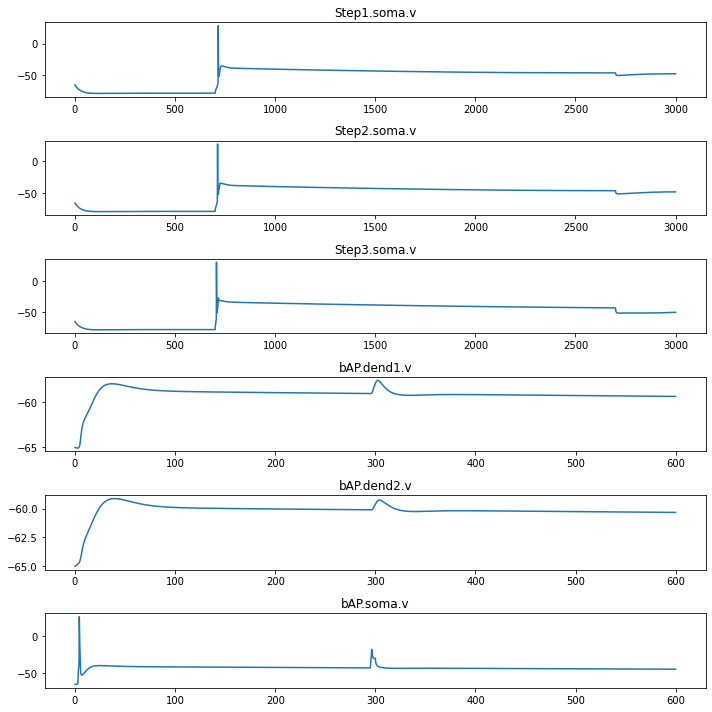

In [23]:
plot_responses(best_responses)